In [14]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import sklearn.metrics as metrics

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
data_path = './data/'

train_ds = torchvision.datasets.FashionMNIST(data_path, download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
test_ds = torchvision.datasets.FashionMNIST(data_path, download=True, train=False,
    transform=transforms.Compose([transforms.ToTensor()])
)

In [5]:
# DataLoader
# batch size 지정, data shuffle

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=100)    # 어떤 데이터를 불러올지 지정하고, batch_size 지정
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=100)

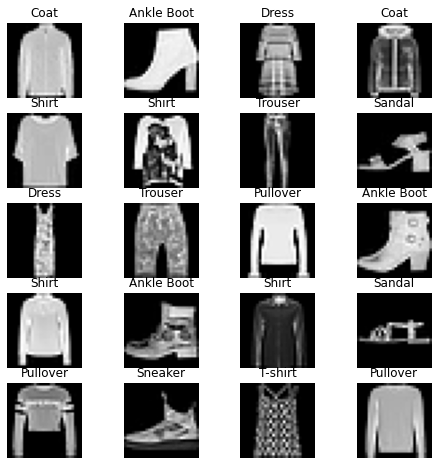

In [6]:
label = {0:'T-shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'}

fig = plt.figure(figsize=(8,8))
cols = 4
rows = 5

for i in range(1, cols*rows +1):
    img_xy = np.random.randint(len(train_ds))
    img = train_ds[img_xy][0][0]                # train_ds[n][0][0] - image array 값 저장되어 있음 (img siez = 28 * 28)
    fig.add_subplot(rows, cols, i)
    plt.title(label[train_ds[img_xy][1]])       # train_ds[n][1] - 레이블 저장되어 있음
    plt.axis('off')
    plt.imshow(img, cmap='gray')

plt.show()

In [7]:
# DNN 모델 생성

class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, input_data):
        out = input_data.view(-1, 784)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        # out = F.log_softmax(out, dim=1)
        return out

In [8]:
# 하이퍼파라미터 정의

lr = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [17]:
# 모델 학습

epochs = 5
count = 0

loss_list = []
iteration_list = []
acc_list = []
pred_list = []
label_list = []

for epoch in range(epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                label_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                pred = torch.max(outputs, 1)[1].to(device)
                pred_list.append(pred)
                correct += (pred == labels).sum()
                total += len(labels)

            acc = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(acc)
        
        if not (count % 500):
            print(f'Iteration: {count}, Loss: {loss.data:.2f}, Acc: {acc:.2f}%')

Iteration: 500, Loss: 0.44, Acc: 86.46%
Iteration: 1000, Loss: 0.40, Acc: 86.53%
Iteration: 1500, Loss: 0.25, Acc: 86.85%
Iteration: 2000, Loss: 0.24, Acc: 87.00%
Iteration: 2500, Loss: 0.19, Acc: 87.14%
Iteration: 3000, Loss: 0.28, Acc: 87.39%


In [18]:
outputs

tensor([[  2.7980, -13.5325,  -2.8584,  -7.3374,  -3.9002,  -9.1937,   4.9531,
         -18.0685,  -5.5403, -13.1500],
        [ -2.6858,  -0.2378,  -5.6688,   4.7530,  -4.8299,  -8.1733,  -3.6128,
         -12.0643,  -6.0706,  -8.7649],
        [  4.8487, -12.0605,  -2.3783,  -6.0581,  -4.7171, -11.3100,   7.4064,
         -21.7395,  -6.6024, -16.5602],
        [ -3.6104,  -9.7654,  -6.1493,  -9.3716,  -3.6869,  -7.7303,  -6.0139,
         -12.3229,   5.6509,  -8.4592],
        [ -3.3777,  -4.4181,  -0.0786,   0.3264,   3.2183,  -6.8867,   1.4634,
          -7.9850,  -3.0090,  -8.1776],
        [-10.0715,  -8.4022, -10.3160,  -4.4925, -11.0339,   1.3775,  -8.5528,
          10.2152,  -5.0337,  -3.9969],
        [ -5.1288,  -7.9856, -10.0407,  -9.8497,  -9.3114,   6.6839,  -9.2652,
           1.0222,  -4.2290,  -1.5254],
        [ -6.2283,  -5.1900,  -6.9751,  -4.9947,  -9.4845,   7.3488,  -7.1654,
          -0.3926,  -5.6936,  -6.3540],
        [ -9.5447,  -6.2745,  -9.3897,  -3.9802,

In [12]:
pred_list

[tensor([9, 2, 1, 1, 6, 1, 4, 4, 7, 7, 4, 9, 7, 3, 4, 1, 2, 6, 8, 0, 0, 7, 7, 7,
         1, 2, 4, 3, 9, 3, 8, 8, 3, 3, 8, 0, 7, 7, 7, 9, 0, 1, 0, 9, 4, 9, 6, 3,
         4, 6, 6, 2, 7, 6, 4, 2, 8, 4, 8, 0, 7, 7, 8, 7, 1, 1, 4, 3, 9, 8, 7, 0,
         6, 0, 4, 3, 1, 2, 8, 4, 1, 8, 5, 9, 7, 0, 3, 4, 0, 6, 5, 3, 4, 7, 1, 8,
         0, 1, 4, 2]),
 tensor([3, 4, 7, 4, 7, 8, 7, 9, 9, 4, 2, 7, 7, 0, 5, 2, 8, 4, 7, 8, 8, 0, 9, 9,
         3, 0, 8, 4, 1, 9, 4, 1, 9, 1, 8, 4, 4, 1, 4, 5, 1, 0, 0, 0, 1, 0, 1, 3,
         6, 4, 6, 4, 1, 3, 7, 0, 4, 7, 9, 3, 7, 2, 3, 9, 0, 9, 4, 9, 4, 6, 0, 7,
         4, 1, 2, 4, 3, 0, 9, 1, 0, 9, 0, 8, 7, 9, 9, 4, 4, 7, 3, 2, 3, 2, 3, 2,
         8, 3, 2, 1]),
 tensor([1, 0, 4, 9, 4, 4, 0, 7, 9, 8, 4, 1, 8, 4, 1, 3, 3, 4, 7, 4, 8, 9, 4, 0,
         7, 7, 0, 4, 7, 0, 7, 8, 9, 2, 9, 0, 9, 1, 4, 2, 5, 8, 9, 2, 4, 8, 4, 4,
         2, 4, 9, 7, 3, 7, 9, 4, 8, 5, 4, 3, 0, 4, 8, 0, 0, 4, 3, 8, 9, 0, 1, 0,
         0, 4, 3, 0, 8, 3, 7, 4, 0, 1, 2, 3, 0, 4, 0, 7, 9, 3, 